In [1]:
import tensorflow as tf
import os
from utils import *
from tqdm import tqdm

In [2]:
attention_win_size = 3
max_N = 180
max_T = 210

def guided_attention(g=0.2):
    W = np.zeros((max_N, max_T), dtype=np.float32)
    for n_pos in range(W.shape[0]):
        for t_pos in range(W.shape[1]):
            W[n_pos, t_pos] = 1 - np.exp(-(t_pos / float(max_T) - n_pos / float(max_N)) ** 2 / (2 * g * g))
    return W

In [3]:
def Attention(Q, inputs, num_units, num_heads = 8, activation = None):
    T_k = tf.shape(inputs)[1]
    T_q = tf.shape(Q)[1]
    K_V = tf.layers.dense(inputs, 2*num_units, activation)
    K, V = tf.split(K_V, 2, -1)
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), 0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), 0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), 0)
    align = tf.matmul(Q_, K_, transpose_b=True)
    align *= tf.rsqrt(tf.to_float(K_.get_shape()[-1].value))
    paddings = tf.fill(tf.shape(align), float('-inf'))
    lower_tri = tf.ones([T_q, T_k])
    lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()
    masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0],1,1])
    align = tf.where(tf.equal(masks, 0), paddings, align)
    align = tf.nn.softmax(align)
    alignments = tf.transpose(align, [0, 2, 1]) 
    x = tf.matmul(align, V_)
    x = tf.concat(tf.split(x, num_heads, axis=0), 2)
    x += Q
    x = layer_norm(x)
    return x, alignments

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta


def cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):
    x = layer_norm(x)
    pad = tf.zeros([tf.shape(x)[0], pad_sz, hidden_dim])
    x =  tf.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
                          filters = hidden_dim,
                          kernel_size = kernel_size,
                          dilation_rate = dilation_rate)
    x = x[:, :-pad_sz, :]
    x = tf.nn.relu(x)
    return x

class Model:
    def __init__(
        self,
        num_layers,
        size_layers,
        learning_rate = 1e-4,
        kernel_size = 5
    ):
        self.X = tf.placeholder(tf.int32, (None, None))
        lookup_table = tf.get_variable(
            'lookup_table',
            dtype = tf.float32,
            shape = [len(vocab), size_layers],
            initializer = tf.truncated_normal_initializer(
                mean = 0.0, stddev = 0.01
            ),
        )
        lookup_table = tf.concat(
            (tf.zeros(shape = [1, size_layers]), lookup_table[1:, :]), 0
        )
        self.gts = tf.convert_to_tensor(guided_attention())
        forward = tf.nn.embedding_lookup(lookup_table, self.X)
        self.Y = tf.placeholder(tf.float32, (None, None, n_mels * resampled))
        batch_size = tf.shape(self.Y)[0]
        self.decoder_inputs = tf.concat(
            (tf.ones_like(self.Y[:, :1, :]), self.Y[:, :-1, :]), 1
        )
        self.decoder_inputs = self.decoder_inputs[:, :, -n_mels:]
        
        self.Z = tf.placeholder(
            tf.float32, (None, None, fourier_window_size // 2 + 1)
        )
        self.prev_max_attentions = tf.placeholder(tf.int32, shape=(1,))
        
        for i in range(num_layers): 
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate 
            with tf.variable_scope('block_%d'%i):
                forward += cnn_block(forward, dilation_rate, pad_sz, size_layers, kernel_size)
                
        encoder = tf.layers.dense(self.decoder_inputs, size_layers)
        
        for i in range(num_layers): 
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate 
            with tf.variable_scope('block_encoder_%d'%i):
                encoder += cnn_block(encoder, dilation_rate, pad_sz, size_layers, kernel_size)
        
        train_R, self.alignments = Attention(encoder, forward, size_layers)
        
        def generate_mel(x, reuse = False):
            with tf.variable_scope('generate_mel', reuse = reuse):
                for i in range(num_layers): 
                    dilation_rate = 2 ** i
                    pad_sz = (kernel_size - 1) * dilation_rate 
                    with tf.variable_scope('block_mel_%d'%i, reuse = reuse):
                        x += cnn_block(x, dilation_rate, pad_sz, size_layers, kernel_size)
                return tf.layers.dense(x, n_mels * resampled)
        
        self.Y_logits = generate_mel(train_R)
        self.Y_hat = tf.sigmoid(self.Y_logits)
        
        self.loss1 = tf.reduce_mean(tf.abs(self.Y_hat - self.Y))
        self.loss_bd1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.Y_logits, 
                                                                               labels=self.Y))
        self.A = tf.pad(self.alignments, [(0, 0), (0, max_N), (0, max_T)], 
                        mode="CONSTANT", constant_values=-1.)[:, :max_N, :max_T]
        self.attention_masks = tf.to_float(tf.not_equal(self.A, -1))
        self.loss_att = tf.reduce_sum(tf.abs(self.A * self.gts) * self.attention_masks)
        self.mask_sum = tf.reduce_sum(self.attention_masks)
        self.loss_att /= self.mask_sum
        
        out_decoder = tf.reshape(
                self.Y, [tf.shape(self.Y)[0], -1, n_mels]
        )
        out_decoder = tf.layers.dense(out_decoder, size_layers)
        
        for i in range(num_layers): 
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate 
            with tf.variable_scope('block_vocoder_%d'%i):
                out_decoder += cnn_block(out_decoder, dilation_rate, pad_sz, size_layers, kernel_size)
        
        self.Z_logits = tf.layers.dense(out_decoder, 1 + fourier_window_size // 2)
        self.Z_hat = tf.sigmoid(self.Z_logits)
        self.loss2 = tf.reduce_mean(tf.abs(self.Z_hat - self.Z))
        self.loss_bd2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.Z_logits, 
                                                                          labels=self.Z))
        self.loss = self.loss1 + self.loss2 + self.loss_bd1 + self.loss_bd2 + self.loss_att
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.loss)

In [4]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

size_layers = 128
learning_rate = 1e-4
num_layers = 4

model = Model(num_layers, size_layers, learning_rate)
sess.run(tf.global_variables_initializer())

In [5]:
paths, lengths, texts, raw_texts = [], [], [], []
text_files = [f for f in os.listdir('mel') if f.endswith('.npy')]
for fpath in text_files:
    with open('%s/%s' % (path, fpath.replace('npy', 'txt'))) as fopen:
        text = fopen.read()
    paths.append(fpath.replace('.npy', ''))
    text = text_normalize(text)
    raw_texts.append(text)
    text = text + 'E'
    texts.append(np.array([char2idx[char] for char in text], np.int32))
    lengths.append(len(text))

In [6]:
def dynamic_batching(paths):
    files, max_y, max_z = [], 0, 0
    for n in range(len(paths)):
        files.append(get_cached(paths[n]))
        if files[-1][0].shape[0] > max_y:
            max_y = files[-1][0].shape[0]
        if files[-1][1].shape[0] > max_z:
            max_z = files[-1][1].shape[0]
    return files, max_y, max_z

minibatch loop: 100%|██████████| 88/88 [00:18<00:00,  3.83it/s, cost=0.887, loss1=0.146, loss2=0.0749, loss_att=0.00245, loss_bd1=0.348, loss_bd2=0.315]


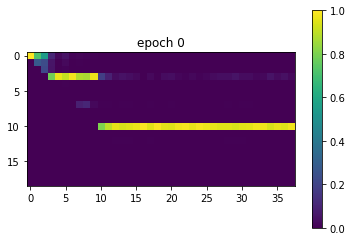

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.63it/s, cost=0.656, loss1=0.0697, loss2=0.0471, loss_att=0.0022, loss_bd1=0.25, loss_bd2=0.287] 


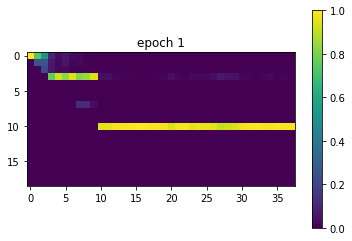

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.62it/s, cost=0.607, loss1=0.0519, loss2=0.0405, loss_att=0.00241, loss_bd1=0.23, loss_bd2=0.282] 


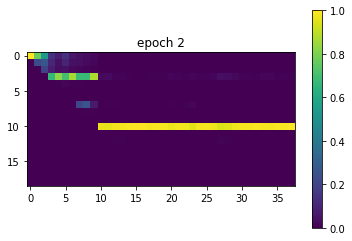

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.56it/s, cost=0.59, loss1=0.0463, loss2=0.0372, loss_att=0.00216, loss_bd1=0.225, loss_bd2=0.279] 


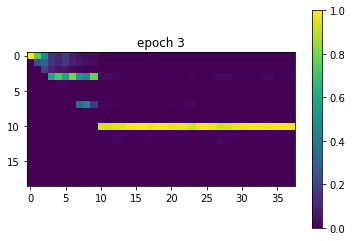

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.72it/s, cost=0.581, loss1=0.0433, loss2=0.0352, loss_att=0.00207, loss_bd1=0.222, loss_bd2=0.278]


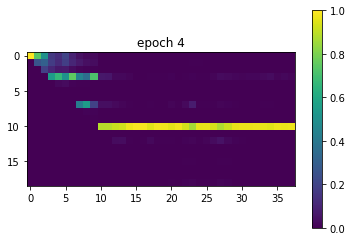

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.60it/s, cost=0.574, loss1=0.0408, loss2=0.0338, loss_att=0.00198, loss_bd1=0.22, loss_bd2=0.277] 


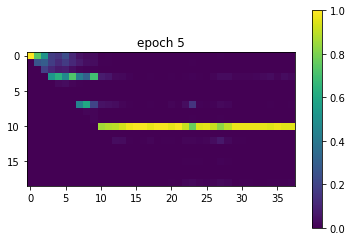

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.66it/s, cost=0.569, loss1=0.0392, loss2=0.0328, loss_att=0.00192, loss_bd1=0.219, loss_bd2=0.277]


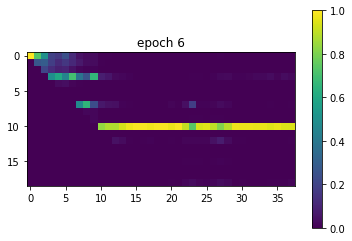

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.59it/s, cost=0.566, loss1=0.0383, loss2=0.0319, loss_att=0.00186, loss_bd1=0.218, loss_bd2=0.276]


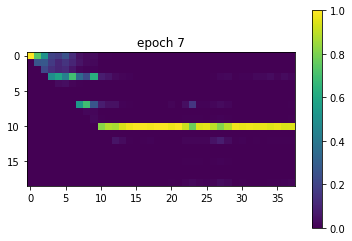

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.59it/s, cost=0.564, loss1=0.0375, loss2=0.0313, loss_att=0.00173, loss_bd1=0.217, loss_bd2=0.276]


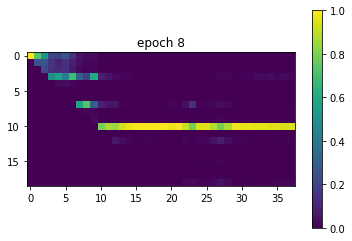

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.65it/s, cost=0.561, loss1=0.0367, loss2=0.0307, loss_att=0.00167, loss_bd1=0.217, loss_bd2=0.276]


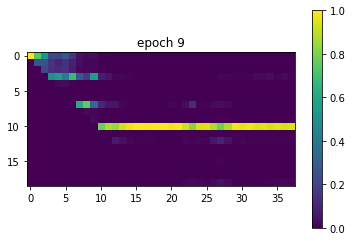

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.64it/s, cost=0.559, loss1=0.0363, loss2=0.0302, loss_att=0.00158, loss_bd1=0.216, loss_bd2=0.275]


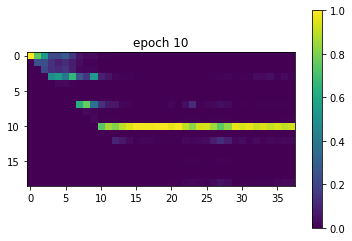

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.69it/s, cost=0.558, loss1=0.0356, loss2=0.0297, loss_att=0.00156, loss_bd1=0.216, loss_bd2=0.275]


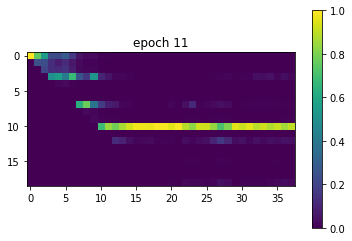

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.62it/s, cost=0.556, loss1=0.0351, loss2=0.0293, loss_att=0.00146, loss_bd1=0.215, loss_bd2=0.275]


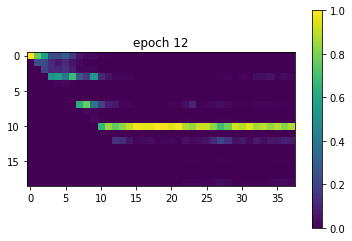

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.67it/s, cost=0.555, loss1=0.0346, loss2=0.029, loss_att=0.00142, loss_bd1=0.215, loss_bd2=0.275] 


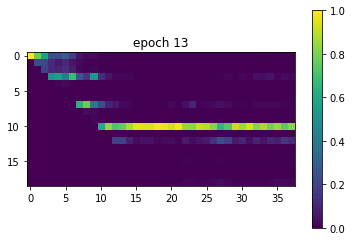

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.64it/s, cost=0.553, loss1=0.0342, loss2=0.0287, loss_att=0.00139, loss_bd1=0.214, loss_bd2=0.275]


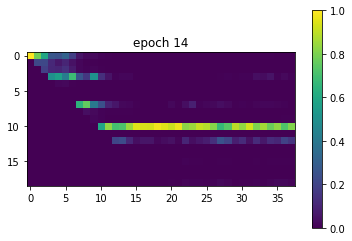

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.73it/s, cost=0.552, loss1=0.0338, loss2=0.0284, loss_att=0.00137, loss_bd1=0.214, loss_bd2=0.274]


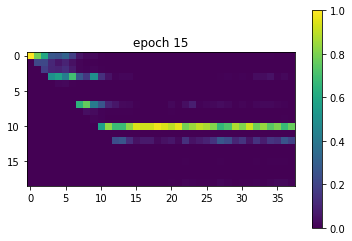

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.69it/s, cost=0.551, loss1=0.0334, loss2=0.0281, loss_att=0.00133, loss_bd1=0.214, loss_bd2=0.274]


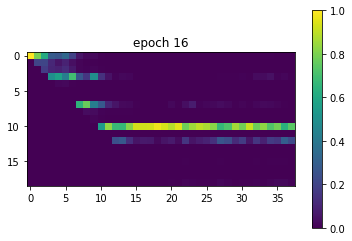

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.73it/s, cost=0.55, loss1=0.033, loss2=0.0278, loss_att=0.00131, loss_bd1=0.213, loss_bd2=0.274]  


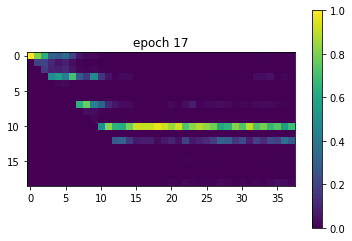

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.70it/s, cost=0.549, loss1=0.0326, loss2=0.0275, loss_att=0.00129, loss_bd1=0.213, loss_bd2=0.274]


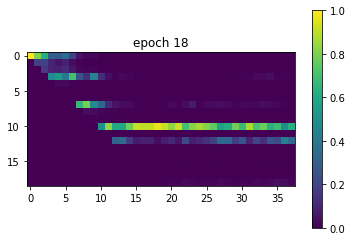

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.65it/s, cost=0.547, loss1=0.0322, loss2=0.0273, loss_att=0.00128, loss_bd1=0.213, loss_bd2=0.274]


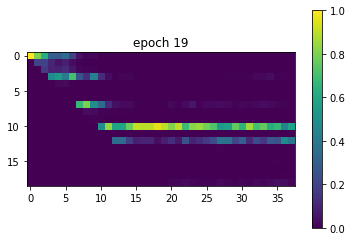

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.63it/s, cost=0.546, loss1=0.0318, loss2=0.0271, loss_att=0.00125, loss_bd1=0.213, loss_bd2=0.274]


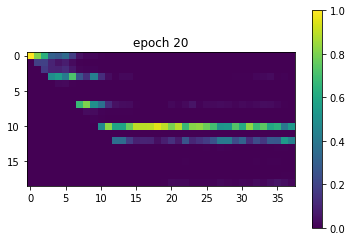

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.69it/s, cost=0.545, loss1=0.0314, loss2=0.0269, loss_att=0.00121, loss_bd1=0.212, loss_bd2=0.274]


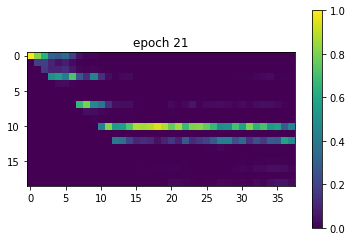

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.71it/s, cost=0.544, loss1=0.031, loss2=0.0267, loss_att=0.00119, loss_bd1=0.212, loss_bd2=0.274] 


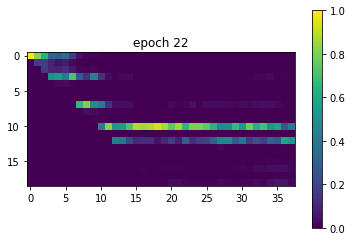

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.66it/s, cost=0.544, loss1=0.0307, loss2=0.0265, loss_att=0.00119, loss_bd1=0.212, loss_bd2=0.274]


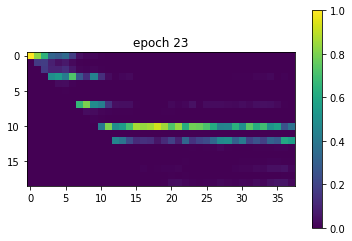

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.69it/s, cost=0.543, loss1=0.0304, loss2=0.0263, loss_att=0.00117, loss_bd1=0.211, loss_bd2=0.273]


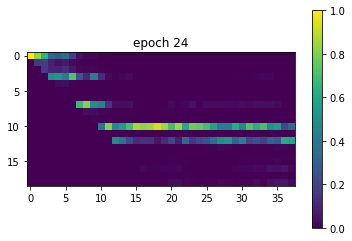

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.73it/s, cost=0.542, loss1=0.0301, loss2=0.0261, loss_att=0.00117, loss_bd1=0.211, loss_bd2=0.273]


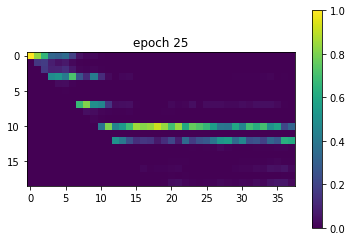

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.63it/s, cost=0.541, loss1=0.0298, loss2=0.0259, loss_att=0.00116, loss_bd1=0.211, loss_bd2=0.273]


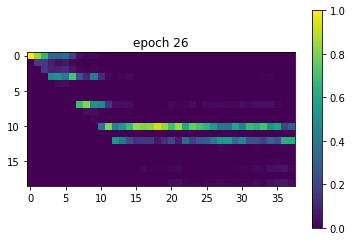

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.57it/s, cost=0.541, loss1=0.0295, loss2=0.0258, loss_att=0.00115, loss_bd1=0.211, loss_bd2=0.273]


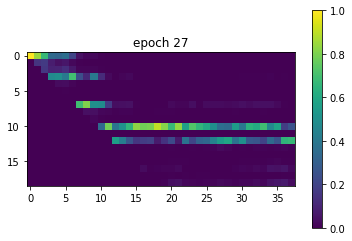

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.64it/s, cost=0.54, loss1=0.0294, loss2=0.0256, loss_att=0.00115, loss_bd1=0.211, loss_bd2=0.273] 


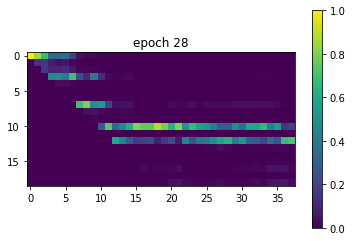

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.63it/s, cost=0.54, loss1=0.0292, loss2=0.0255, loss_att=0.00113, loss_bd1=0.211, loss_bd2=0.273] 


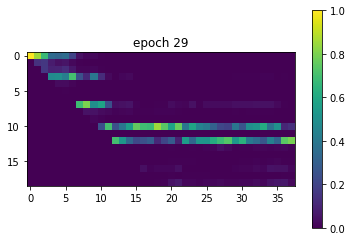

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.65it/s, cost=0.539, loss1=0.0288, loss2=0.0253, loss_att=0.00113, loss_bd1=0.21, loss_bd2=0.273] 


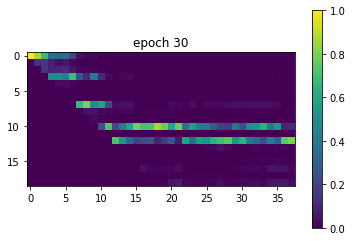

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.58it/s, cost=0.539, loss1=0.029, loss2=0.0252, loss_att=0.00113, loss_bd1=0.21, loss_bd2=0.273]  


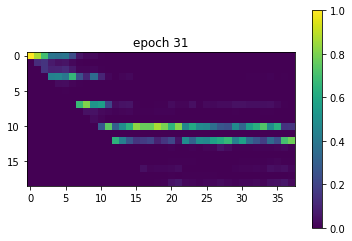

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.65it/s, cost=0.538, loss1=0.0285, loss2=0.025, loss_att=0.00112, loss_bd1=0.21, loss_bd2=0.273]  


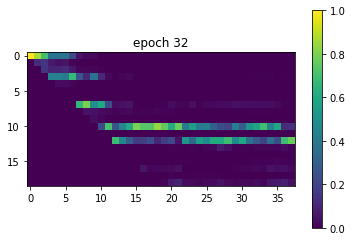

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.64it/s, cost=0.537, loss1=0.0283, loss2=0.0249, loss_att=0.00112, loss_bd1=0.21, loss_bd2=0.273] 


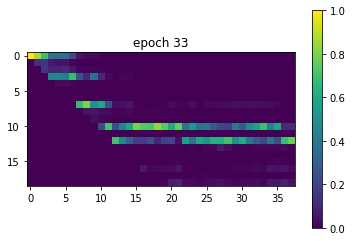

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.60it/s, cost=0.537, loss1=0.0281, loss2=0.0248, loss_att=0.00111, loss_bd1=0.21, loss_bd2=0.273] 


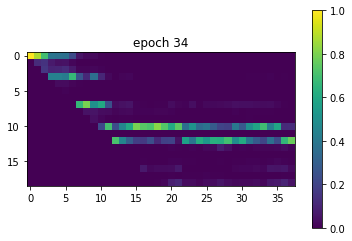

minibatch loop: 100%|██████████| 88/88 [00:14<00:00,  6.55it/s, cost=0.536, loss1=0.0279, loss2=0.0247, loss_att=0.00111, loss_bd1=0.21, loss_bd2=0.273] 


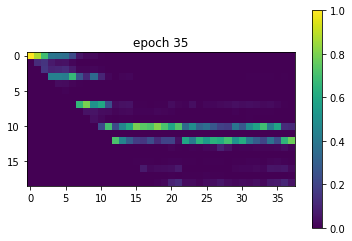

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.59it/s, cost=0.536, loss1=0.0277, loss2=0.0246, loss_att=0.0011, loss_bd1=0.21, loss_bd2=0.273]  


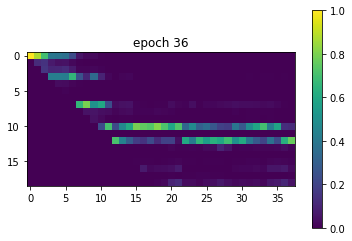

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.65it/s, cost=0.535, loss1=0.0276, loss2=0.0245, loss_att=0.0011, loss_bd1=0.209, loss_bd2=0.273] 


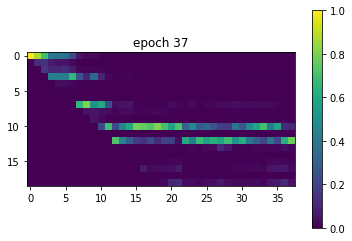

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.54it/s, cost=0.535, loss1=0.0274, loss2=0.0244, loss_att=0.0011, loss_bd1=0.209, loss_bd2=0.273] 


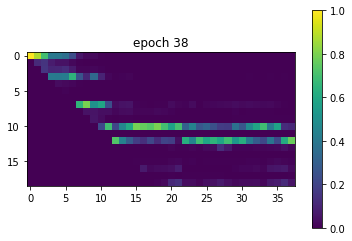

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.63it/s, cost=0.534, loss1=0.0272, loss2=0.0243, loss_att=0.00109, loss_bd1=0.209, loss_bd2=0.273]


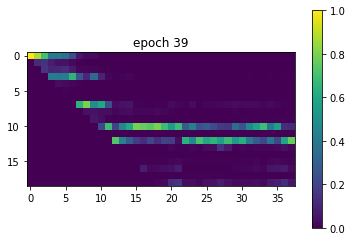

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.55it/s, cost=0.534, loss1=0.0271, loss2=0.0242, loss_att=0.00109, loss_bd1=0.209, loss_bd2=0.272]


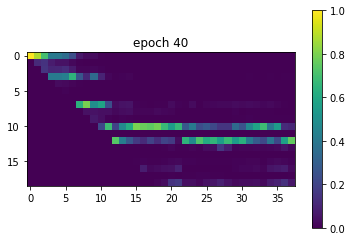

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.65it/s, cost=0.534, loss1=0.027, loss2=0.024, loss_att=0.00108, loss_bd1=0.209, loss_bd2=0.272]  


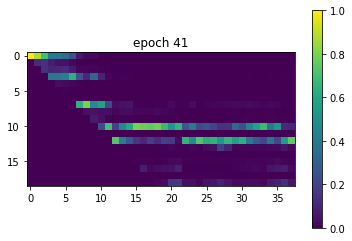

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.64it/s, cost=0.533, loss1=0.0268, loss2=0.0239, loss_att=0.00108, loss_bd1=0.209, loss_bd2=0.272]


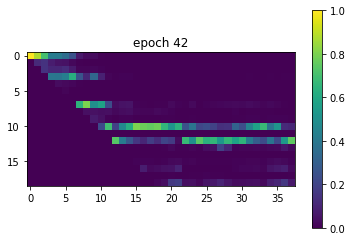

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.55it/s, cost=0.533, loss1=0.0267, loss2=0.0238, loss_att=0.00107, loss_bd1=0.209, loss_bd2=0.272]


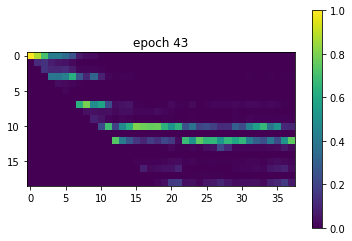

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.64it/s, cost=0.532, loss1=0.0266, loss2=0.0237, loss_att=0.00106, loss_bd1=0.209, loss_bd2=0.272]


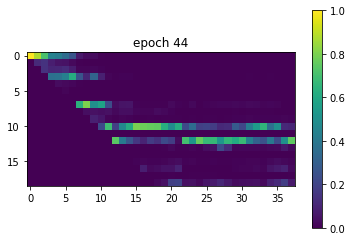

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.70it/s, cost=0.532, loss1=0.0265, loss2=0.0236, loss_att=0.00105, loss_bd1=0.209, loss_bd2=0.272]


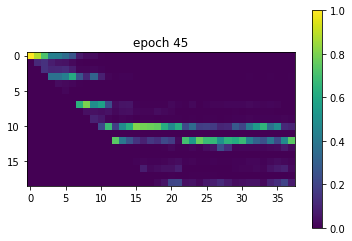

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.68it/s, cost=0.532, loss1=0.0264, loss2=0.0235, loss_att=0.00105, loss_bd1=0.209, loss_bd2=0.272]


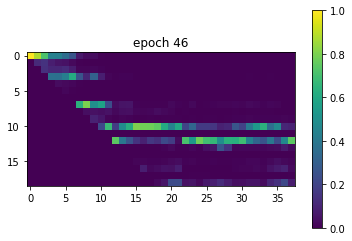

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.63it/s, cost=0.531, loss1=0.0262, loss2=0.0235, loss_att=0.00104, loss_bd1=0.209, loss_bd2=0.272]


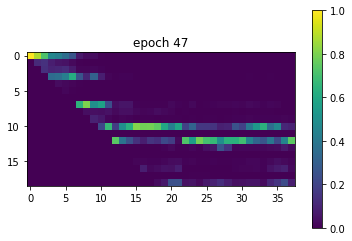

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.68it/s, cost=0.531, loss1=0.0261, loss2=0.0234, loss_att=0.00104, loss_bd1=0.208, loss_bd2=0.272]


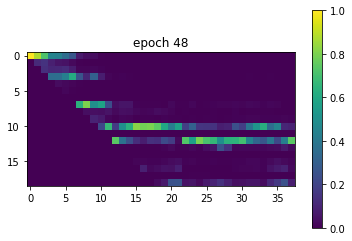

minibatch loop: 100%|██████████| 88/88 [00:13<00:00,  6.67it/s, cost=0.531, loss1=0.026, loss2=0.0233, loss_att=0.00103, loss_bd1=0.208, loss_bd2=0.272] 


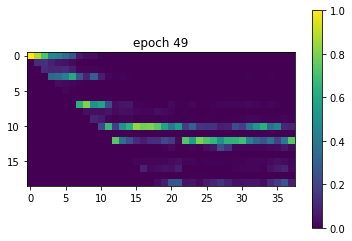

In [8]:
EPOCH = 50
for i in range(EPOCH):
    pbar = tqdm(range(0, len(paths), batch_size), desc = 'minibatch loop')
    for k in pbar:
        index = min(k + batch_size, len(paths))
        files, max_y, max_z = dynamic_batching(paths[k:index])
        max_x = max(lengths[k:index])
        batch_x = np.zeros((batch_size, max_x))
        batch_y = np.zeros((batch_size, max_y, n_mels * resampled))
        batch_z = np.zeros((batch_size, max_z, fourier_window_size // 2 + 1))
        for n in range(len(files)):
            batch_x[n, :] = np.pad(
                texts[k + n],
                ((0, max_x - texts[k + n].shape[0])),
                mode = 'constant',
            )
            batch_y[n, :, :] = np.pad(
                files[n][0],
                ((0, max_y - files[n][0].shape[0]), (0, 0)),
                mode = 'constant',
            )
            batch_z[n, :, :] = np.pad(
                files[n][1],
                ((0, max_z - files[n][1].shape[0]), (0, 0)),
                mode = 'constant',
            )
        _, cost, loss1, loss2, loss_bd1, loss_att, loss_bd2 = sess.run(
            [model.optimizer, model.loss, 
            model.loss1, model.loss2, model.loss_bd1,
            model.loss_att, model.loss_bd2],
            feed_dict = {model.X: batch_x, model.Y: batch_y, model.Z: batch_z},
        )
        pbar.set_postfix(cost = cost, loss1 = loss1, loss2 = loss2, loss_bd1 = loss_bd1,
                        loss_att = loss_att, loss_bd2 = loss_bd2)
        
    align = sess.run(
        model.alignments, feed_dict = {model.X: batch_x, model.Y: batch_y}
    )
    plot_alignment(align[0, :, :], i)

In [9]:
y_hat = np.ones((1, batch_y.shape[1], n_mels * resampled), np.float32)
for j in tqdm(range(batch_y.shape[1])):
    _y_hat = sess.run(model.Y_hat, {model.X: [texts[0]], model.Y: y_hat})
    y_hat[:, j, :] = _y_hat[:, j, :]

100%|██████████| 38/38 [00:00<00:00, 117.51it/s]


In [10]:
mags = sess.run(model.Z_hat, {model.Y: y_hat})
audio = spectrogram2wav(mags[0])

In [11]:
import IPython.display as ipd
ipd.Audio(audio, rate = sample_rate)

In [12]:
from scipy.io.wavfile import write
print('saving: %s'%(raw_texts[0]))
write(os.path.join('test-dilated-cnn-self-attention.wav'), sample_rate, audio)

saving: say the word burn


In [13]:
mags = sess.run(model.Z_hat, {model.Y: [batch_y[0]]})
audio = spectrogram2wav(mags[0])
ipd.Audio(audio, rate = sample_rate)

In [14]:
real_audio = spectrogram2wav(batch_z[0])
ipd.Audio(real_audio, rate = sample_rate)